In [2]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams["figure.figsize"] = (3,3)
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp

Bifurcations de populations de neurones
======================

Le but de ce projet est de simuler l'évolution de l'activité moyenne de groupes de neurones en intéraction, à l'aide d'un modèle simplifié de *Wilson-Cowan*. En notant $x=(x_1,...,x_i,..., x_n)\in \mathbb{R}^n$ le vecteur contenant l'activité moyenne de chacun des $n$ groupes de neurones, ce modèle s'écrit (en grandeurs normalisées)
$$
\tau \dot x = - x + S(Wx + d^{\rm ext})
$$
où $\tau$ est une constante de temps, $W \in \mathbb{R}^{n\times n}$ est une matrice décrivant les intéractions entre groupes de neurones, $d^{\rm ext}\in \mathbb{R}^n$ peut contenir des stimulis/perturbations extérieurs impactant chaque groupe, et $S: \mathbb{R}^n \to \mathbb{R}^n$ est de la forme
$$
S({\rm x}_1,...,{\rm x}_i ,...,{\rm x}_n) = (s_1({\rm x}_1),...,s_i({\rm x}_i),...,s_n({\rm x}_n))
$$
où $s_i:\mathbb{R}\to \mathbb{R}$ sont des fonctions dîtes d'*activation*.

Ces fonctions d'activation permettent de modéliser le fait que l'activité environnante d'un groupe de neurone doit atteindre un certain seuil avant d'exciter ce groupe. Des choix courants de fonctions d'activation sont la tangente hyperbolique ou des sigmoides de la forme
$$
s({\rm x}) = \frac{1}{1+ e^{-a(x-\theta)}}-\frac{1}{1+e^{a\theta}}
$$
où $\theta$ représente le seuil d'activation et $a$ sa pente, comme illustré ci-dessous. 

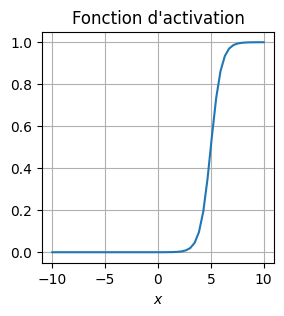

In [3]:
def sigmoid(x):
    a = 2.0   # la pente au niveau du seuil est a/4
    theta = 5.0  # seuil
    return 1/(1+np.exp(-a*(x-theta)))-1/(1+np.exp(a*theta))

x = np.linspace(-10,10)
plt.figure()
plt.plot(x,sigmoid(x))
plt.grid(True)
plt.xlabel('$x$')
plt.title("Fonction d'activation")
plt.show()

Notons que si l'on réécrit l'équation différentielle composante par composante, on trouve que la dynamique de chaque groupe de neurone s'écrit
$$
\tau \dot x_i = -x_i + s_i\left(\sum_{j=1}^n w_{ij}x_j + d_{i}^{\rm ext}\right)
$$

**Question 1** Justifier que si les fonctions d'activation $s_i:\mathbb{R}\to \mathbb{R}$ sont bornées (minorées et majorées) alors toutes les solutions maximales $t\mapsto x(t)$ sont définies sur $\mathbb{R}$ et sont bornées. Relier la borne de $t\mapsto x_i(t)$ à la borne de $s_i$ pour chaque $i$. 


**Réponse Question 1** 
Montrons que toutes les solutions maximales $t\mapsto x(t)$ sont définies et bornées sur $\mathbb{R}$

Comme $\tau>0 $, on peut écrire $$
\dot x = f(x)
$$ avec $f$ fonction continue de $\mathbb{R}^n$ dans $\mathbb{R}^n$ $$
f(x)= \frac{1}{\tau} \left(- x + S(Wx + d^{\rm ext})\right)
$$

Soit $M_i$ la borne de $s_i$ pour chaque $i$. Alors $S$ est bornée par $M=M_1+M_2+...+M_n$ Donc $$
\forall x\in\mathbb{R}^n, \|f(x)\|\leq\frac{1}{\|\tau\|}\cdot \|x\| + \frac{1}{\|\tau\|}\cdot M
$$ 
Donc par critère d'existence globale, toutes les solutions maximales $t\mapsto x(t)$ sont définies sur $\mathbb{R}$

REMARQUE : pour trouver M, on fait comme si on était en norme 1 (puisqu'on aditionne), est ce qu'il faut pas parler d'équivalence des normes ou qqc comme ça ? c'est pour ça qu'au début, j'avais mis f bornée par $\|M\|$ où M=(M1,M2,...,Mn). ou on dit que f est bornée par M sans expliciter le lien entre M et M1,M2,...,Mn.
REPONSE JULIE : je pense qu'on peut dire qu'on est en dim finie donc equivalence des normes et qu'avec la norme infini c'est ok non ?


Pour simplifier, on étudie ce système en dimension 2, c'est-à-dire avec deux groupes de neurones: le premier ayant un effet *excitant* et le deuxième *inhibant*. On traduit cela par la matrice d'interconnection suivante.

In [5]:
W = np.array([[5.0, -4.0], [8.0, -1.0]])
print(W)

[[ 5. -4.]
 [ 8. -1.]]


On fixe aussi $s_1=s_2$ données par la sigmoide ci-dessus, ainsi que $\tau=1$ puisque faire varier $\tau$ ne change que l'échelle de temps. On va essayer d'étudier et exploiter la grande richesse de comportements asymptotiques possibles pour différentes valeurs de $d^{\rm ext}$.

Points d'équilibre
================

On commence par considérer $d^{\rm ext}$ constant. Ses composantes $d_1^{\rm ext}$ et $d_2^{\rm ext}$ peuvent donc être vus comme des paramètres du système. Les points d'équilibre $x^{\rm eq}\in \mathbb{R}^n$ se caractérisent alors par l'équation
$$
x^{\rm eq} = S(W x^{\rm eq} + d^{\rm ext})
$$
La fonction suivante trace les points $(x_1,x_2)$ tels que $-x_1+s(w_{11}x_1+w_{12}x_2+d_1^{\rm ext})=0$ (en rouge) et $-x_2+s(w_{21}x_1+w_{22}x_2+d_2^{\rm ext})=0$ (en vert) pour des valeurs de $d^{\rm ext}$ à choisir.

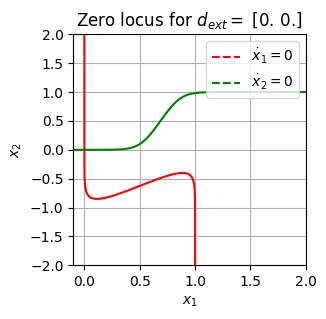

In [29]:
def plot_zero_locus(d_ext):
    grid_x1 = np.linspace(-0.1,2.0,100)
    grid_x2 = np.linspace(-2.0,2.0,100)
    X1, X2 = np.meshgrid(grid_x1,grid_x2)

    X1dot = -X1 + sigmoid(W[0,0]*X1 + W[0,1]*X2 + d_ext[0])
    X2dot = -X2 + sigmoid(W[1,0]*X1 + W[1,1]*X2 + d_ext[1])

    plt.figure()
    C1 = plt.contour(X1, X2, X1dot, 0, colors = 'red')
    C2 = plt.contour(X1, X2, X2dot, 0, colors = 'green')
    h1,_ = C1.legend_elements()
    h2,_ = C2.legend_elements()
    plt.grid(True)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend([h1[0],h2[0]],['$\dot x_1 = 0$','$\dot x_2 = 0$'])
    plt.title("Zero locus for $d_{ext} =$ "+ str(d_ext))
    plt.show()
    return


d_ext = np.array([0.0,0.0])  # A CHOISIR
plot_zero_locus(d_ext)

**Question 2** Identifier le point d'équilibre du système pour $d^{\rm ext}=0$ et étudier sa stabilité. 

**Question 3** Tester d'autres valeurs de $d^{\rm ext}$. Par exemple, fixer $d^{\rm ext}_2=4$, et faire varier $d^{\rm ext}_1$ entre 3 et 8. Qu'observe-t-on sur le nombre de points d'équilibre ? Pour $d^{\rm ext}=(6,4)$, on trace ci-dessous le portrait de phase. Retrouver graphiquement les points d'équilibre et intuiter leur stabilité. Quels sont les seuls comportements asymptotiques possibles des solutions pour cette valeur constante de $d^{\rm ext}$ ?

**Réponse question 2** 
On observe une intersection des courbes pour des valeurs qui semblent être proches de $x^{\rm eq}_1=0$ et $x^{\rm eq}_2=0$. Or cette intersection correspond au point d'équilibre du système. On vérifie ensuite par le calcul que le point (0,0) est bien un point d'équilibre, autrement dit s'il satisfait les deux équations suivantes : 
$-x_1+s(w_{11}x_1+w_{12}x_2+d_1^{\rm ext})=0$ et $-x_2+s(w_{21}x_1+w_{22}x_2+d_2^{\rm ext})=0$
C'est bien le cas. Nous avons donc trouvé le point d'équilibre.

Il s'agit maintenant d'étudier sa stabilité. 
Pour cela, on utilise le théorème qui fait le lien entre stabilité et stabilité du linéarisé tangent.
On a :
$$\dot x = f(x)
$$ avec
$$
f(x)=- x + S(Wx + d^{\rm ext})
$$ $f$ est continuement différentiable et présente un point d'équilibre en (0,0).
Sa matrice jacobienne en (0,0) s'écrit : 
\begin{bmatrix}
-1 + \frac{10e^{10}}{(1+ e^{10})^2}  & \frac{-8e^{10}}{(1+ e^{10})^2} \\
\frac{16e^{10}}{(1+ e^{10})^2} & -1 + \frac{-2e^{10}}{(1+ e^{10})^2}
\end{bmatrix}

Sa trace étant négative et son déterminant positif, on en déduit que les parties réelles de ses valeurs propres sont négatives. On peut s'en assurer à l'aide de la fonction suivante : 

In [7]:
def jacobienne (x1,x2):
    jac = np.array([[-1+(10*np.exp(-2*(5*x1-4*x2-5)))/((1+np.exp(-2*(5*x1-4*x2-5)))**2), (-8*np.exp(-2*(5*x1-4*x2-5)))/((1+np.exp(-2*(5*x1-4*x2-5)))**2)],
                    [(16*np.exp(-2*(8*x1-x2-5)))/((1+np.exp(-2*(8*x1-x2-5)))**2),-1+(-2*np.exp(-2*(8*x1-x2-5)))/((1+np.exp(-2*(8*x1-x2-5)))**2)]])
    return(np.linalg.eigvals(jac))
print(jacobienne (0,0))

[-0.99981842+0.00043542j -0.99981842-0.00043542j]


On en déduit que (0,0) est localement asymptotiquement stable. En observant le portrait de phase, on peut également supposer que ce point est globalement asymptotiquement stable.

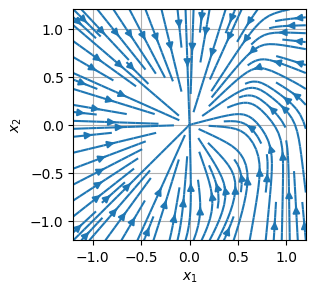

In [8]:
d_ext = np.array([0.0,0.0])  

grid_x1 = np.linspace(-1.2,1.2,70)
grid_x2 = np.linspace(-1.2,1.2,70)
X1, X2 = np.meshgrid(grid_x1,grid_x2)

X1dot = -X1 + sigmoid(W[0,0]*X1 + W[0,1]*X2 + d_ext[0])
X2dot = -X2 + sigmoid(W[1,0]*X1 + W[1,1]*X2 + d_ext[1])

plt.figure()
plt.streamplot(grid_x1, grid_x2, X1dot, X2dot)
plt.grid(True)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

**Réponse question 3** 
On commence par fixer $d^{\rm ext}_2=4$, et faire varier $d^{\rm ext}_1$ entre 3 et 5. On observe toujours un seul point d'équilibre.

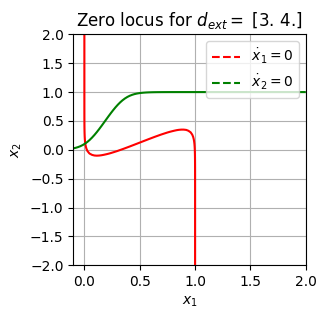

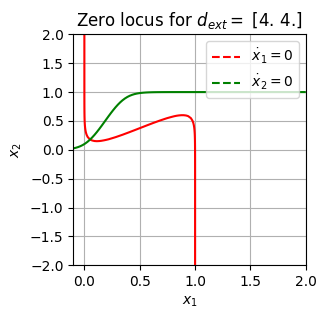

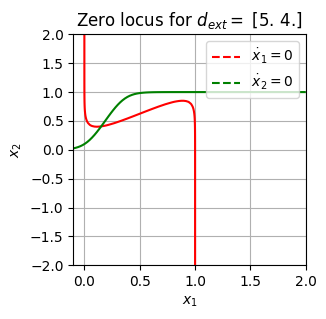

In [9]:
d_ext = np.array([3.0,4.0]) 
plot_zero_locus(d_ext)

d_ext = np.array([4.0,4.0]) 
plot_zero_locus(d_ext)

d_ext = np.array([5.0,4.0]) 
plot_zero_locus(d_ext)

Mais lorsqu'on continue d'augmenter $d^{\rm ext}_1$, plusieurs points d'équilibres apparaissent.

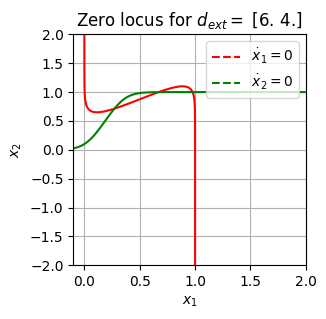

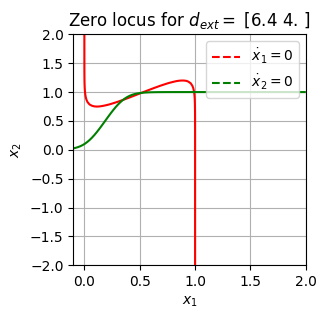

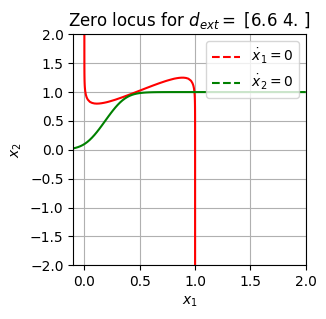

In [16]:
d_ext = np.array([6.0,4.0]) 
plot_zero_locus(d_ext)

d_ext = np.array([6.4,4.0]) 
plot_zero_locus(d_ext)

d_ext = np.array([6.6,4.0])  
plot_zero_locus(d_ext)

Puis, en augmentant à nouveau, il ne reste plus qu'un seul point d'équilibre.

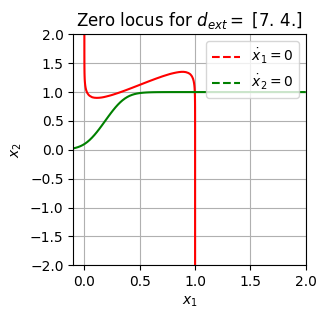

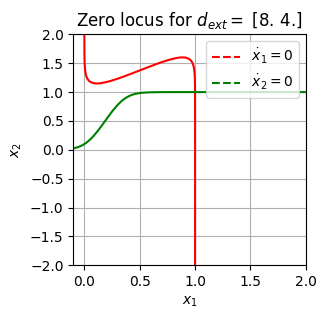

In [17]:
d_ext = np.array([7.0,4.0])
plot_zero_locus(d_ext)
d_ext = np.array([8.0,4.0]) 
plot_zero_locus(d_ext)

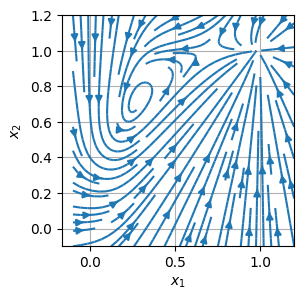

In [10]:
d_ext = np.array([6.0,4.0])  

grid_x1 = np.linspace(-0.1,1.2,70)
grid_x2 = np.linspace(-0.1,1.2,70)
X1, X2 = np.meshgrid(grid_x1,grid_x2)

X1dot = -X1 + sigmoid(W[0,0]*X1 + W[0,1]*X2 + d_ext[0])
X2dot = -X2 + sigmoid(W[1,0]*X1 + W[1,1]*X2 + d_ext[1])

plt.figure()
plt.streamplot(grid_x1, grid_x2, X1dot, X2dot)
plt.grid(True)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

A partir de ce portrait de phase on peut conjecturer l'existence de trois points d'équilibres : (1.0;1.0),(0.3;0.7), (0.7;1.0). 
On peut intuiter que les points (1.0;1.0) et (0.3;0.7) sont des points d'équilibre localement asymptotiquement stable car les lignes du portrait de phase semblent converger vers ces points. En revanche, le point (0.7;1.0) paraît être un point d'équilibre instable car les lignes du portrait de phase semblent fuir ce point. Les seuls comportements asymptotiques possibles pour cette valeur de $d^{\rm ext}_2$ sont des comportements locaux car il y a plusieurs points d'équilibre.

Lorsque le nombre et la nature (stabilité) des points d'équilibre changent brusquement avec des modifications de paramètres, on parle de *bifurcation*. De tels phénomènes permettent généralement de produire des comportements asymptotiques extrêmement riches et variés, simplement en faisant varier ces paramètres. Nous en étudions plusieurs exemples dans la suite.

Simulation des trajectoires
================

**Question 4** Compléter la fonction ``solve_euler_explicit`` ci-dessous prenant en entrée une fonction $f: \mathbb{R}\times\mathbb{R}^n \to \mathbb{R}^n$ quelconque, une condition initiale $x_0$, un pas de temps $dt$, les temps initiaux et finaux, et renvoyant e vecteur des temps $t^j$ et de la solution $x^j$ du schéma d'Euler explicite appliqué à $\dot{x}=f(t,x)$.

In [11]:
def solve_euler_explicit(f, x0, dt, t0, tf):
    n = len(x0)
    m = int((tf-t0)//dt)
    t = np.zeros(m)
    x = np.zeros((m,n))
    t[0] = t0
    x[0] = x0
    for i in range (m-1):
        t[i+1] = t[i] + dt
        x[i+1] = x[i] + dt*f(t[i],x[i])
    return(t,x)

def f(t,x): #TO TEST
    x1,x2=x
    return(t*x1*x2,x1+x2)

print(solve_euler_explicit(f,(0,2),1,0,10))

(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([[   0.,    2.],
       [   0.,    4.],
       [   0.,    8.],
       [   0.,   16.],
       [   0.,   32.],
       [   0.,   64.],
       [   0.,  128.],
       [   0.,  256.],
       [   0.,  512.],
       [   0., 1024.]]))


**Question 5** Expliquer (sans le faire) comment on pourrait trouver numériquement l'ordre de convergence de ce schéma.


**Réponse question 5** 
reponse hypothétique à comprendre :
Pour déterminer numériquement l'ordre de convergence de ce schéma, on pourrait procéder ainsi :
On commence par fixer un pas de temps dt0. On utilise ensuite notre algorithme solver_euler_explicit sur la même fonction f, avec les mêmes valeurs de x0, t0, tf mais en faisant diminuer successivement les valeurs de dt. On pourra par exemple prendre les valeurs dt0, dt0/2, dt0/4...
On calculera ensuite la norme de la différence entre chaque résultat successif. On pourra tracer la courbe du logarithme de la différence en fonction du logarithme du pas de temps. On calculera ensuite la pente de la courbe avec une régression linéaire. Or l'ordre de convergence du schéma sera donné par l'inverse de cette pente. En effet ...
**Agathe** Je crois que j'ai compris ce que tu veux dire : problème : on est inférieur, pas égal. Donc la régression linéaire ne va probablement pas donner p
D'après la définition de la convergence, un schéma numérique est convergent d'ordre p s'il existe $c_v >0$ une constante telle que
$$
\max_{1\leq j\leq J}\|x^j-x(t_j)\|\leq c_v (\Delta t)^p 
$$où   $\Delta t=max_{1\leq j\leq J}\Delta t_j$

**Réponse question 5** IDEE
On pourrait utiliser le théorème de Lax. Si f est lipschitzienne en x, alors le schéma est stable d'après la condition suffisante de stabilité comme on a $\Phi(t,x,\Delta t) =f(\Delta t,x)$
Puis pour trouver l'ordre de consistance on pourrait utiliser non pas la définition mais la CNS de consistance d'ordre >= p. $\Phi=f$ et est C infini donc Cp pour tout p. On regarde jusqu'à quel k on a 
$$
\frac{\partial^k\Phi}{\partial \Delta t^k}(t,x,0)=\frac{1}{k+1} f^{[k]}(t,x)
$$
L'ordre est alors $k_{max}+1$

**Question 6** On utilise maintenant ``solve_euler_explicit`` pour simuler des trajectoires de neurones lorsque $d^{\rm ext}$ est constant. En vous aidant du portrait de phase de la question 3, illustrer les comportements asymptotiques possibles des solutions pour $d^{\rm ext}=(6,4)$, en choisissant différentes conditions initiales. Lequel ne peut-on pas illustrer numériquement ?

**Réponse question 6**
Parmi les 3 points d'équilibres trouvés à la question 3, on ne pourra pas illustrer numériquement le point d'équilibre instable. Néanmoins, il est possible de le faire pour les points d'équilibre stable si on choisit une condition initiale suffisamment proche de ces points. Par exemple pour le point situé approximativement en (1.0;1.0), on pourra donner la condition initiale (0.95;0.95) et obtenir le résultat suivant :  

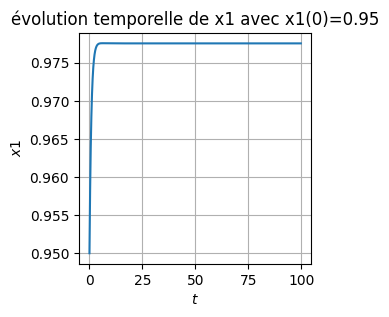

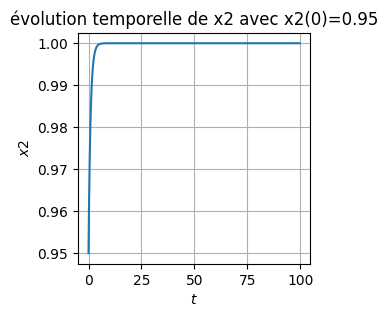

Le point d'équilibre est situé en ( 0.9775529186529996 ; 0.9999458039355726 )


In [24]:
def f_d_ext_constant(t,x):
    d_ext = np.array([6.0,4.0])
    return -x + sigmoid(np.dot(W,x)+d_ext)

x0 = (0.95,0.95)
dt = 0.1
t0, tf = 0.0, 100.0
time, x = solve_euler_explicit(f_d_ext_constant, x0, dt, t0, tf)
x1=np.array([x[i][0] for i in range(len(x))])
x2=np.array([x[i][1] for i in range(len(x))])

plt.figure()
plt.plot(time,x1)
plt.grid(True)
plt.xlabel('$t$')
plt.ylabel('$x1$')
plt.title("évolution temporelle de x1 avec x1(0)=0.95")
plt.show()

plt.figure()
plt.plot(time,x2)
plt.grid(True)
plt.xlabel('$t$')
plt.ylabel('$x2$')
plt.title("évolution temporelle de x2 avec x2(0)=0.95")
plt.show()

print ("Le point d'équilibre est situé en (",x[len(x)-1][0],";",x[len(x)-1][1],")")

Ici on stabilise bien vers le point d'équilibre annoncé.
On souhaite maintenant retrouver le point d'équilibre stable situé en (0.3;0.7). Pour cela on impose la condition initiale (0.3;0.7) et on obtient :

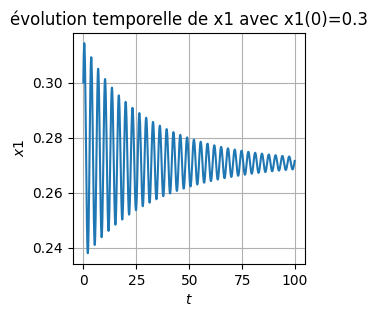

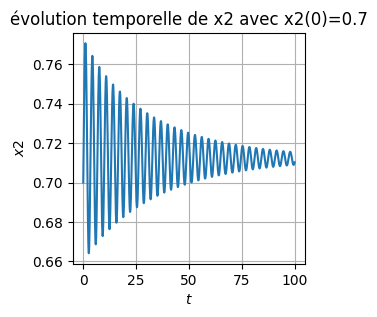

Le point d'équilibre est situé en ( 0.27148282357916076 0.7102762455435099 )


In [26]:
x0 = (0.3,0.7)
dt = 0.1
t0, tf = 0.0, 100.0
time, x = solve_euler_explicit(f_d_ext_constant, x0, dt, t0, tf)
x1=np.array([x[i][0] for i in range(len(x))])
x2=np.array([x[i][1] for i in range(len(x))])

plt.figure()
plt.plot(time,x1)
plt.grid(True)
plt.xlabel('$t$')
plt.ylabel('$x1$')
plt.title("évolution temporelle de x1 avec x1(0)=0.3")
plt.show()

plt.figure()
plt.plot(time,x2)
plt.grid(True)
plt.xlabel('$t$')
plt.ylabel('$x2$')
plt.title("évolution temporelle de x2 avec x2(0)=0.7")
plt.show()

print ("Le point d'équilibre est situé en (",x[len(x)-1][0],x[len(x)-1][1],")")

Et sur une échelle de temps un peu plus longue : 

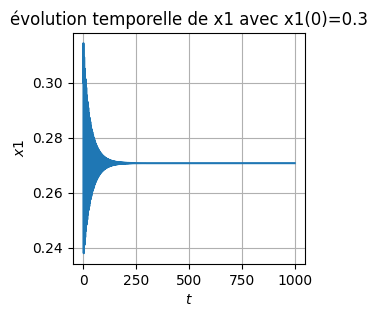

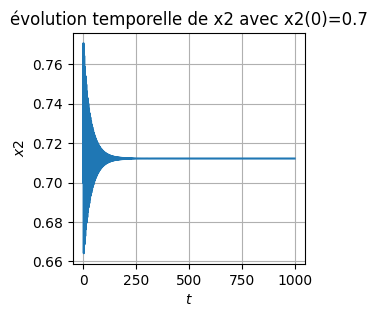

Le point d'équilibre est situé en ( 0.27067655003585755 0.712216037968717 )


In [27]:
x0 = (0.3,0.7)
dt = 0.1
t0, tf = 0.0, 1000.0
time, x = solve_euler_explicit(f_d_ext_constant, x0, dt, t0, tf)
x1=np.array([x[i][0] for i in range(len(x))])
x2=np.array([x[i][1] for i in range(len(x))])

plt.figure()
plt.plot(time,x1)
plt.grid(True)
plt.xlabel('$t$')
plt.ylabel('$x1$')
plt.title("évolution temporelle de x1 avec x1(0)=0.3")
plt.show()

plt.figure()
plt.plot(time,x2)
plt.grid(True)
plt.xlabel('$t$')
plt.ylabel('$x2$')
plt.title("évolution temporelle de x2 avec x2(0)=0.7")
plt.show()

print ("Le point d'équilibre est situé en (",x[len(x)-1][0],x[len(x)-1][1],")")

De la même manière qu'avec le premier point, on se stabilise bien au niveau du point d'équilibre souhaité. Il peut être intéressant de remarquer que les régimes pris par le système avant de se stabiliser ont varié entre les deux points : dans le premier cas le régime semblait apériodique alors qu'il parait ici être pseudo-périodique.

**Question 7** On fixe maintenant $d_2^{\rm ext}=8$ et on fait varier $d_1^{\rm ext}$ lentement de 4 à 8, puis de 8 à 4. En utilisant ``plot_zero_locus``, justifier le comportement de la solution obtenue. Tracer la solution en fonction de $d_1^{\rm ext}$, comment appelle-t-on ce phénomène ? Justifier que l'on parle de *mémoire courte*.

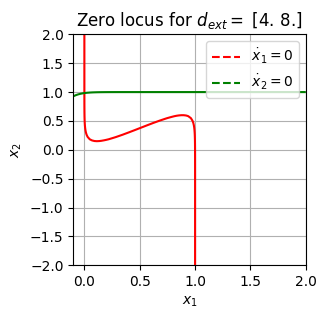

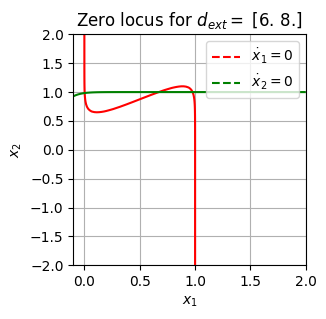

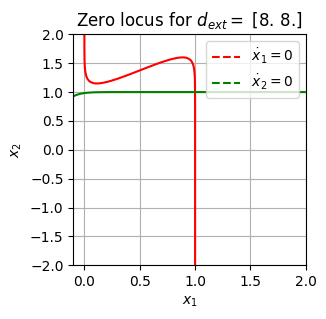

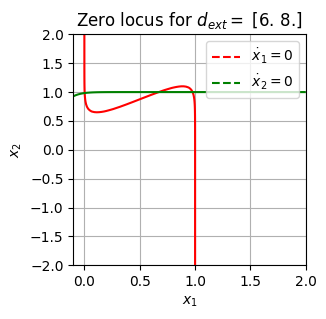

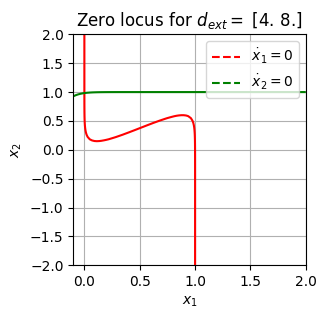

In [33]:
def d_ext_varying(t):
    d1_ext = (0.1*t+4)*(t<40)+(8-0.1*(t-40))*(t>=40)
    d2_ext = 8.0*np.ones(np.shape(t))
    return np.array([d1_ext,d2_ext])

def f_d_ext_varying(t,x):
    return -x + sigmoid(np.dot(W,x)+d_ext_varying(t))

x0 = np.array([0.0,1.0])
dt = 0.1
t0, tf = 0.0, 80.0
time, x = solve_euler_explicit(f_d_ext_varying, x0, dt, t0, tf)

plot_zero_locus(d_ext_varying(0))
plot_zero_locus(d_ext_varying(20))
plot_zero_locus(d_ext_varying(40))
plot_zero_locus(d_ext_varying(60))
plot_zero_locus(d_ext_varying(80))

**Réponse question 7**
D'après ces différents graphiques on peut intuiter que la solution commencera par avoir un point d'équilibre en (0.0;1.0), puis trois, avant de retourner à un seul point d'équilibre, cette fois-ci en (1.0;1.0). A partir de t=40, le même cycle se reproduira à l'envers, passant par trois points d'équilibre et finissant par un unique point d'équilibre en (0.0;1.0).
On trace donc la solution en fonction de $d_1^{\rm ext}$:

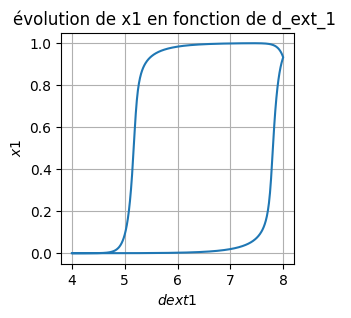

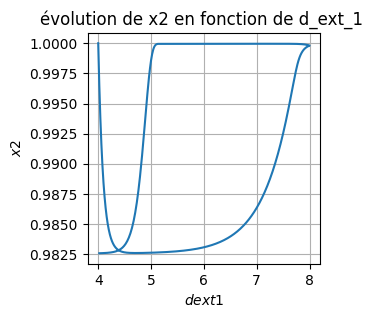

In [43]:
x1=np.array([x[i][0] for i in range(len(x))])
x2=np.array([x[i][1] for i in range(len(x))])

d_ext1=[d_ext_varying(t)[0] for t in time]

plt.figure()
plt.plot(d_ext1,x1)
plt.grid(True)
plt.xlabel('$dext1$')
plt.ylabel('$x1$')
plt.title("évolution de x1 en fonction de d_ext_1 ")
plt.show()

plt.figure()
plt.plot(d_ext1,x2)
plt.grid(True)
plt.xlabel('$dext1$')
plt.ylabel('$x2$')
plt.title("évolution de x2 en fonction de d_ext_1 ")
plt.show()

On peut parler de mémoire courte en observant le graphique de x2 en fonction de $d_1^{\rm ext}$ : on remarque de pour une valeur de $d_1^{\rm ext}$ identique (approximativement située en $d_1^{\rm ext}$=4.3), deux issues très différentes sont possibles.
**Attente de ta validation**

Bendixon et cycle limite
============================

On cherche maintenant à faire apparaître un cycle limite oscillatoire. On s'appuie pour cela sur le théorème de *Bendixon* qui décrit le comportement possible de solutions bornées d'équations différentielles en dimension 2:

    ''Pour une équation différentielle de dimension 2 définie par une fonction continument différentiable, toute solution maximale bornée converge soit vers un point soit vers une fonction périodique du temps appelée *cycle limite*''
    
**Question 8** Justifier que l'on recherche alors une valeur de $d_{\rm ext}$ pour laquelle le système admet un seul point d'équilibre et pour laquelle ce point est instable. 

**Question 9** La fonction ci-dessous permet de tracer les zéros de la dynamique comme ci-dessus mais superposés aux zones où la trace de la jacobienne de $f$ est strictement négative et son déterminant strictement positif. Compléter le calcul de la jacobienne et proposer une méthode empirique pour trouver une valeur de $d_{\rm ext}$ donnant un cycle limite. Vérifier en simulation l'apparition de ce cycle limite.

**Réponse question 8** 
idée de réponse pas bien rédigée : si il y a un point d'équilibre stable, alors toute solution maximale reste "proche" de a

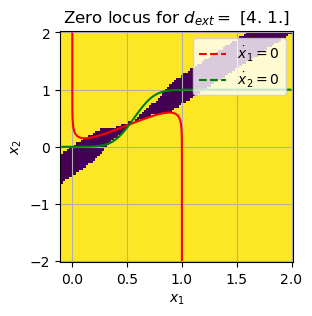

In [19]:
def jacobian_dynamics(x1,x2,d_ext):
    return # A COMPLETER

def plot_zero_locus_stabilite(d_ext):
    N = 100
    grid_x1 = np.linspace(-0.1,2.0,N)
    grid_x2 = np.linspace(-2.0,2.0,N)
    X1, X2 = np.meshgrid(grid_x1,grid_x2)

    X1dot = -X1 + sigmoid(W[0,0]*X1 + W[0,1]*X2 + d_ext[0])
    X2dot = -X2 + sigmoid(W[1,0]*X1 + W[1,1]*X2 + d_ext[1])

    # compute trace and determinant of jacobian matrix on the grid
    tr = np.zeros((N,N))
    deter = np.zeros((N,N))
    for i in np.arange(N):
        for j in np.arange(N):
            tr[i,j] = np.trace(jacobian_dynamics(X1[i,j],X2[i,j],d_ext))
            deter[i,j] = np.linalg.det(jacobian_dynamics(X1[i,j],X2[i,j],d_ext))

    # plot zone where  the trace of the jacobian is negative and its determinant positive
    plt.figure()
    plt.pcolormesh(X1,X2,(tr<0)*(deter>0))

    # root locus plot
    C1 = plt.contour(X1, X2, X1dot, 0, colors = 'red')
    C2 = plt.contour(X1, X2, X2dot, 0, colors = 'green')
    h1,_ = C1.legend_elements()
    h2,_ = C2.legend_elements()
    plt.grid(True)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend([h1[0],h2[0]],['$\dot x_1 = 0$','$\dot x_2 = 0$'])
    plt.title("Zero locus for $d_{ext} =$ "+ str(d_ext))
    plt.show()

    return

plot_zero_locus_stabilite(np.array([4.0,1.0]))